# Задача по предсказанию количества заказов такси
Хотим привлекать водителей в период максимальной нагрузки в аэропортах, для этого предлагаем на исторических данных построить модель предсказывающую количество заказов на следующий час 

# 1. Изучим данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

Загрузим данные и посмотрим на них

In [2]:
df = pd.read_csv(r'C:\Users\Nikolay\My_DS_projects\datasets\taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет - сделаем поле datetime индексом нашего датафрейма

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('datetime')
df.sort_index(inplace=True)

Задача подразумевает предсказывание на следующий час, а у нас интервалы в 10 минут - сделаем ресемплинг

In [5]:
df = df.resample('1H').sum()

# 2. Анализируем

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Наш временной ряд начинается в марте и заканчивается в конце лета 31 августа. Посмотрим тренд и сезонность

In [7]:
def decompose_and_draw(df, description):
    decomposed = seasonal_decompose(df)
    plt.figure(figsize=(10, 20))
    
    plt.subplot(511)
    decomposed.trend.plot(ax=plt.gca(), grid=True)
    plt.title(description + ' Тренд')
    
    plt.subplot(512)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title(description + ' Сезонность')
    
    plt.subplot(513)
    decomposed.resid.plot(ax=plt.gca())
    plt.title(description + ' Остаток')
    
    plt.subplot(514)
    decomposed.seasonal.iloc[-24*7:-1].plot(ax=plt.gca())
    plt.title(description + ' Сезонность последняя неделя')
    plt.subplot(515)

    decomposed.seasonal.iloc[-25:-1].plot(ax=plt.gca())
    plt.title(description + ' Сезонность последний день')
    
    plt.tight_layout()

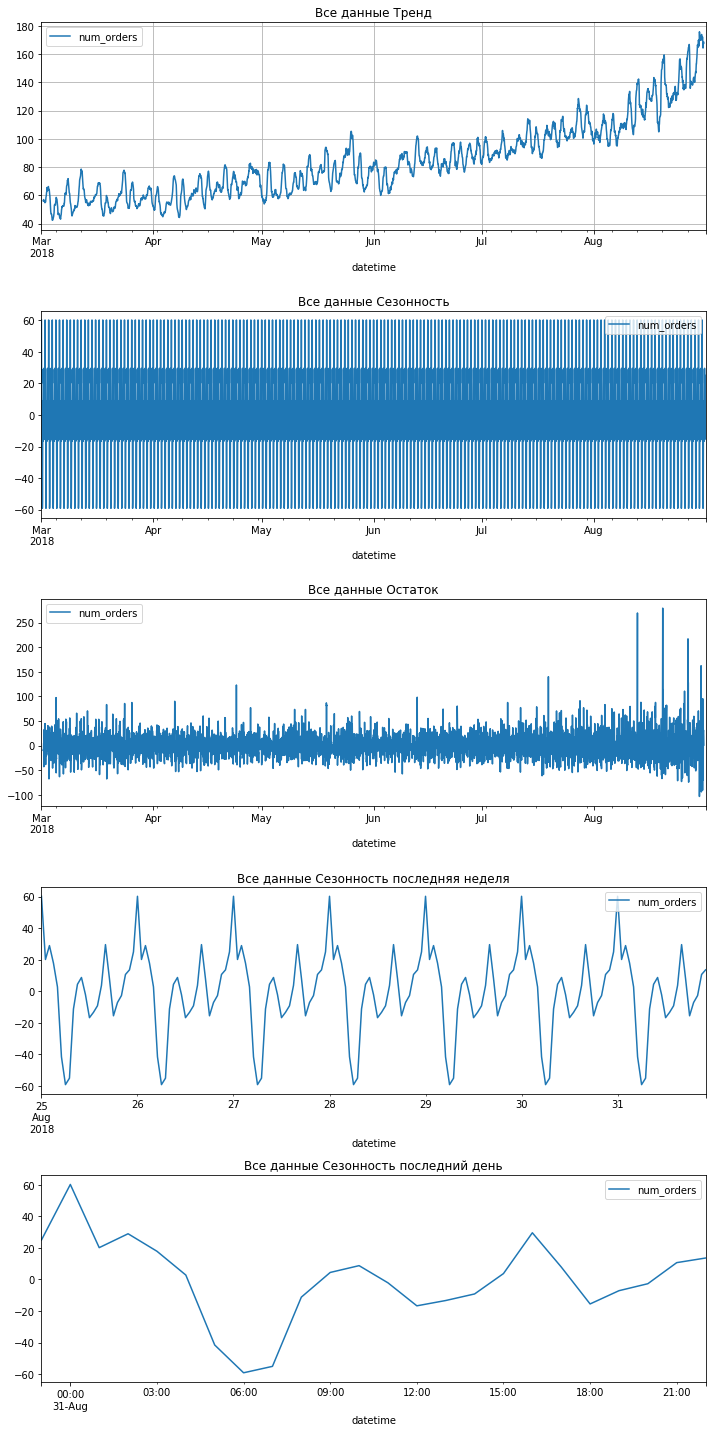

In [8]:
decompose_and_draw(df, 'Все данные')

Есть постоянно растущий тренд. Видим в данных ежедневно повторяющийся паттерн сезонности - пик заказов в полночь, минимум в 6:00, два пика поменьше в 9:00 и 17:00 и дальнейший рост к максимуму в полночь

Посмотрим скользящее среднее/среднее отклонение и разности ряда

In [9]:
df_copy = df.copy()

Text(0.5, 1.0, 'Скользящее среднее и среднее отклонение')

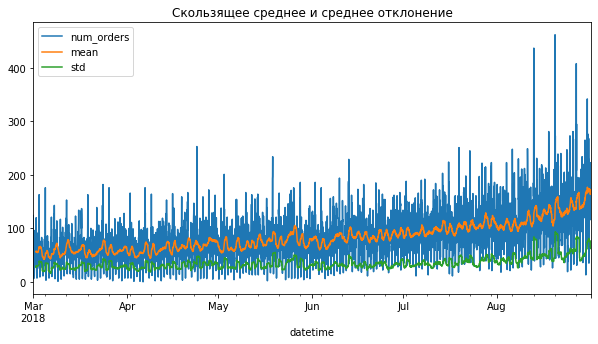

In [10]:
df_copy['mean'] = df_copy['num_orders'].rolling(24).mean()
df_copy['std'] = df_copy['num_orders'].rolling(24).std()
df_copy.plot(figsize=(10, 5))
plt.title('Скользящее среднее и среднее отклонение')

Text(0.5, 1.0, 'Разности ряда')

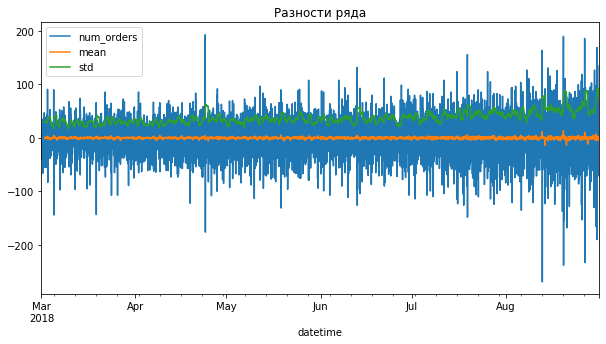

In [11]:
df_copy = df_copy - df_copy.shift()
df_copy['mean'] = df_copy['num_orders'].rolling(24).mean()
df_copy['std'] = df_copy['num_orders'].rolling(24).std()
df_copy.plot(figsize=(10, 5))
plt.title('Разности ряда')

# 3. Делаем модели

Напишем функцию разделения датафрейма на обучающую и тестовую выборку

In [12]:
def separate(df, size):
    X = df.drop('num_orders',axis=1)
    y = df['num_orders']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=False)
    return X_train, X_test, y_train, y_test

Функция создания признаков

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df = df.dropna()
    return df

Переберем варианты признаков и подберем лучший на простой линейной регресии

In [14]:
def simple_liner_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train,y_train)
    test_predict = model.predict(X_test)
    train_predict = model.predict(X_train)
    return mean_squared_error(y_test,test_predict)**0.5

In [15]:
find_best_lag_and_rolling = []
for i in range(2, 48):
    for j in range(2, 48):        
        tmp = make_features(df, i, j)
        X_train, X_test, y_train, y_test = separate(tmp, 0.1)        
        liner_rmse = simple_liner_model(X_train, X_test, y_train, y_test)      
        find_best_lag_and_rolling.append([i,j,liner_rmse])

In [16]:
find_best_lag_and_rolling_df = pd.DataFrame(data=find_best_lag_and_rolling, columns=['lag','rol','rmse'])
find_best_lag_and_rolling_df = find_best_lag_and_rolling_df.sort_values(by='rmse').reset_index(drop=True).head()

In [17]:
find_best_lag_and_rolling_df

,lag,rol,rmse
0,45,47,43.697601
1,47,5,43.811645
2,47,20,43.816836
3,44,47,43.817219
4,47,11,43.817800


In [18]:
best_lag = find_best_lag_and_rolling_df.loc[0,'lag']
best_roll = find_best_lag_and_rolling_df.loc[0,'rol']

Напишем функции которые будут обучать для нас модели

Случайный лес

In [19]:
def run_forest(X_train, X_test, y_train, y_test, splits):
    rmse = make_scorer(mean_squared_error, greater_is_better=False)
    print('Сначала подберем max_depth, min_samples_splitint и min_samples_leafint')
    model = RandomForestRegressor(random_state=41, bootstrap=False)
    param_grid = {'max_depth': range(1,100,10),
        'min_samples_split': range(2,100,10),
        'min_samples_leaf': range(1,100,10),
        'n_estimators': [1]
        }
    gs = GridSearchCV(model, param_grid, scoring=rmse, cv=TimeSeriesSplit(n_splits=splits))
    gs.fit(X_train, y_train)
    best_params = gs.best_params_
    print('Лучшие параметры',best_params)
    
    print('На лучишх параметрах обучим обучающую выборку выборку и увличим параметр n_estimatorsint')
    best_params['n_estimators']=300
    model = RandomForestRegressor(**best_params, random_state=41, bootstrap=False)
    model.fit(X_train, y_train)    
    pred = model.predict(X_test)
    print('RMSE', mean_squared_error(y_test,pred)**0.5)
    return pd.Series(pred,index=y_test.index)    

Регрессия

In [26]:
def run_catboost(X_train, X_test, y_train, y_test, splits):    
    rmse = make_scorer(mean_squared_error, greater_is_better=False)
    print('Сначала подберем depth,learning_rate и l2_leaf_reg')
    model = CatBoostRegressor(loss_function='RMSE', iterations=1, verbose=False)
    grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
    grid_search_result = model.grid_search(grid, X_train, y_train, shuffle=False, cv=TimeSeriesSplit(n_splits=splits), verbose=False)
      
    best_params = grid_search_result.get('params')
    print('Лучшие параметры',best_params)
    
    print('На лучишх параметрах обучим обучающую выборку выборку и увличим параметр iterations')
    best_params['iterations']=300
    model = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)
    model.fit(X_train, y_train)    
    pred = model.predict(X_test)
    print('RMSE', mean_squared_error(y_test,pred)**0.5)
    return pd.Series(pred,index=y_test.index)

Функция для визуализации ряда целевых признаков и предсказаний

In [21]:
def visualization_pred(y_test, y_pred_test):
    plt.figure(figsize=(12, 12))    
    plt.subplot(211)
    y_test.plot(linewidth=1)
    y_pred_test.plot(linewidth=1, color='red')
    plt.title('Фактические значения и предсказания')
    
    plt.subplot(212)
    abs(y_test-y_pred_test).plot()
    plt.title('Модуль разницы фактических значений и предсказаний')
    decompose_and_draw(abs(y_test-y_pred_test), 'Модуль разницы фактических значений и предсказаний')

# 4. Тестируем

Разделим выборку на обучающую и тестовую (для валидации передадим в аргумент cv TimeSeriesSplit с параметром 2)

In [22]:
tmp = make_features(df, best_lag, best_roll)
X_train, X_test, y_train, y_test = separate(tmp, 0.1)

Перед проверкой качества наших моделей сделаем прогноз по медиане и предсказание по предыдущему зачению для проверки на адекватность

In [23]:
pred_median = np.ones(y_test.shape) * y_train.median()
print("RMSE предсказаний по медиане:", mean_squared_error(y_test,pred_median)**0.5)

pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print("RMSE предсказаний по предыдущему значению:", mean_squared_error(y_test,pred_previous)**0.5)

RMSE предсказаний по медиане: 87.35888260909353
RMSE предсказаний по предыдущему значению: 59.01904048345839


Пробуем случайный лес

Сначала подберем max_depth, min_samples_splitint и min_samples_leafint
Лучшие параметры {'max_depth': 11, 'min_samples_leaf': 51, 'min_samples_split': 2, 'n_estimators': 1}
На лучишх параметрах обучим обучающую выборку выборку и увличим параметр n_estimatorsint
RMSE 52.018004170950476


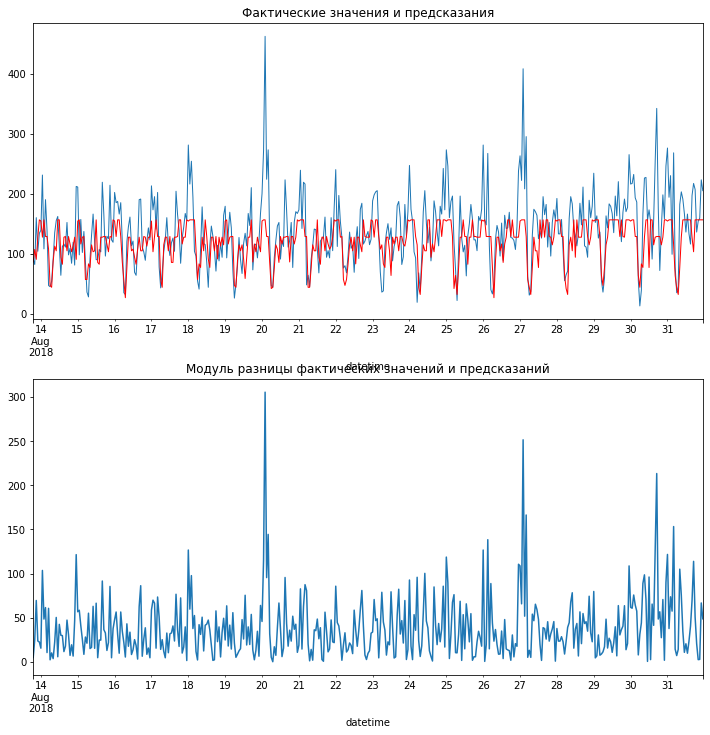

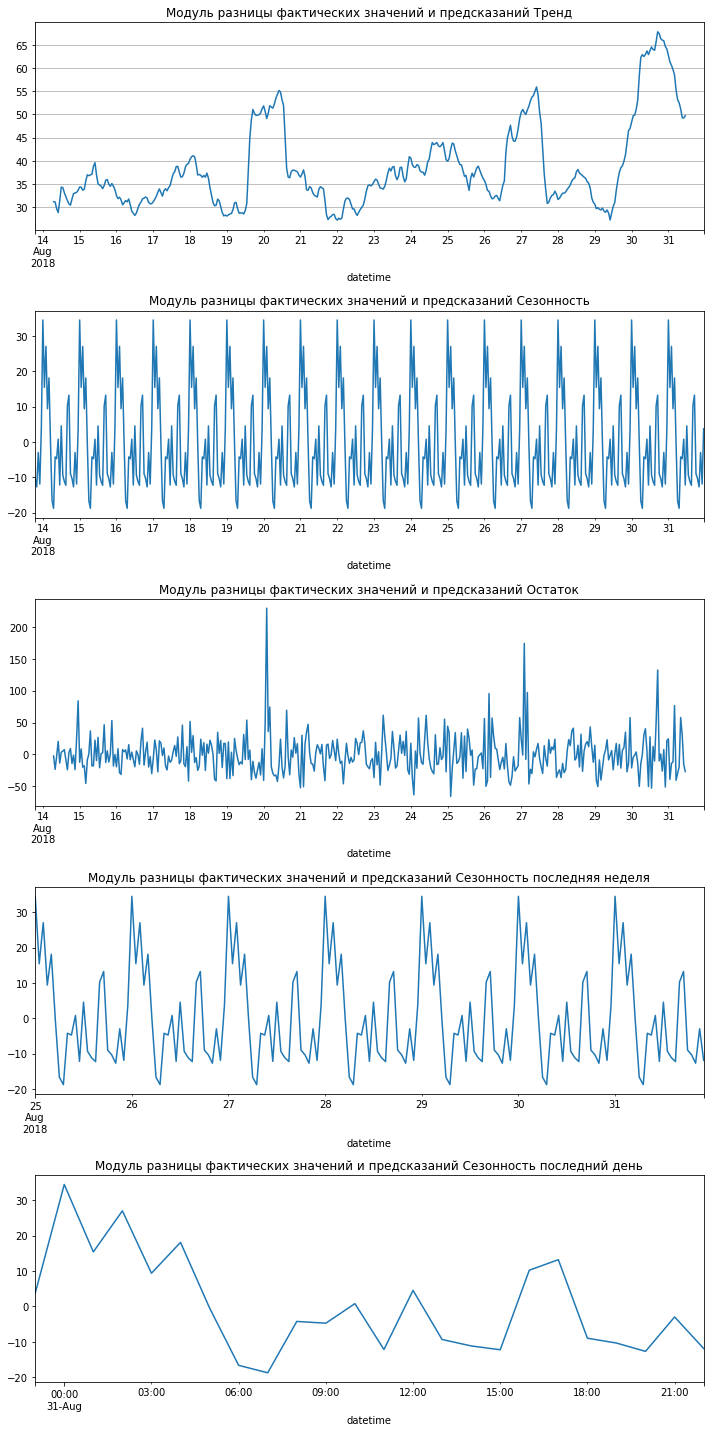

In [24]:
y_pred_test = run_forest(X_train, X_test, y_train, y_test, 2)
visualization_pred(y_test, y_pred_test)

Попробуем регрессию CatBoost

Сначала подберем depth,learning_rate и l2_leaf_reg

bestTest = 112.4872581
bestIteration = 0


bestTest = 106.8505296
bestIteration = 0


bestTest = 91.02188546
bestIteration = 0


bestTest = 112.5030335
bestIteration = 0


bestTest = 106.9027296
bestIteration = 0


bestTest = 91.1739437
bestIteration = 0


bestTest = 112.5185318
bestIteration = 0


bestTest = 106.9540254
bestIteration = 0


bestTest = 91.32351634
bestIteration = 0


bestTest = 112.5337636
bestIteration = 0


bestTest = 107.0044507
bestIteration = 0


bestTest = 91.47068315
bestIteration = 0


bestTest = 112.5487389
bestIteration = 0


bestTest = 107.0540367
bestIteration = 0


bestTest = 91.61551961
bestIteration = 0


bestTest = 112.5276047
bestIteration = 0


bestTest = 106.9855349
bestIteration = 0


bestTest = 91.43112634
bestIteration = 0


bestTest = 112.5701569
bestIteration = 0


bestTest = 107.12864
bestIteration = 0


bestTest = 91.87241275
bestIteration = 0


bestTest = 112.5979229
bestIteration = 0


bestT

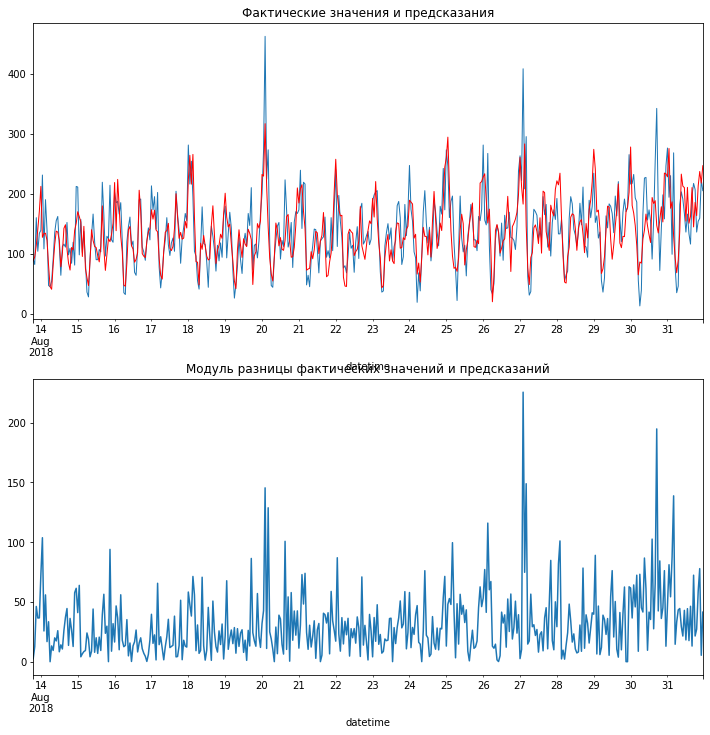

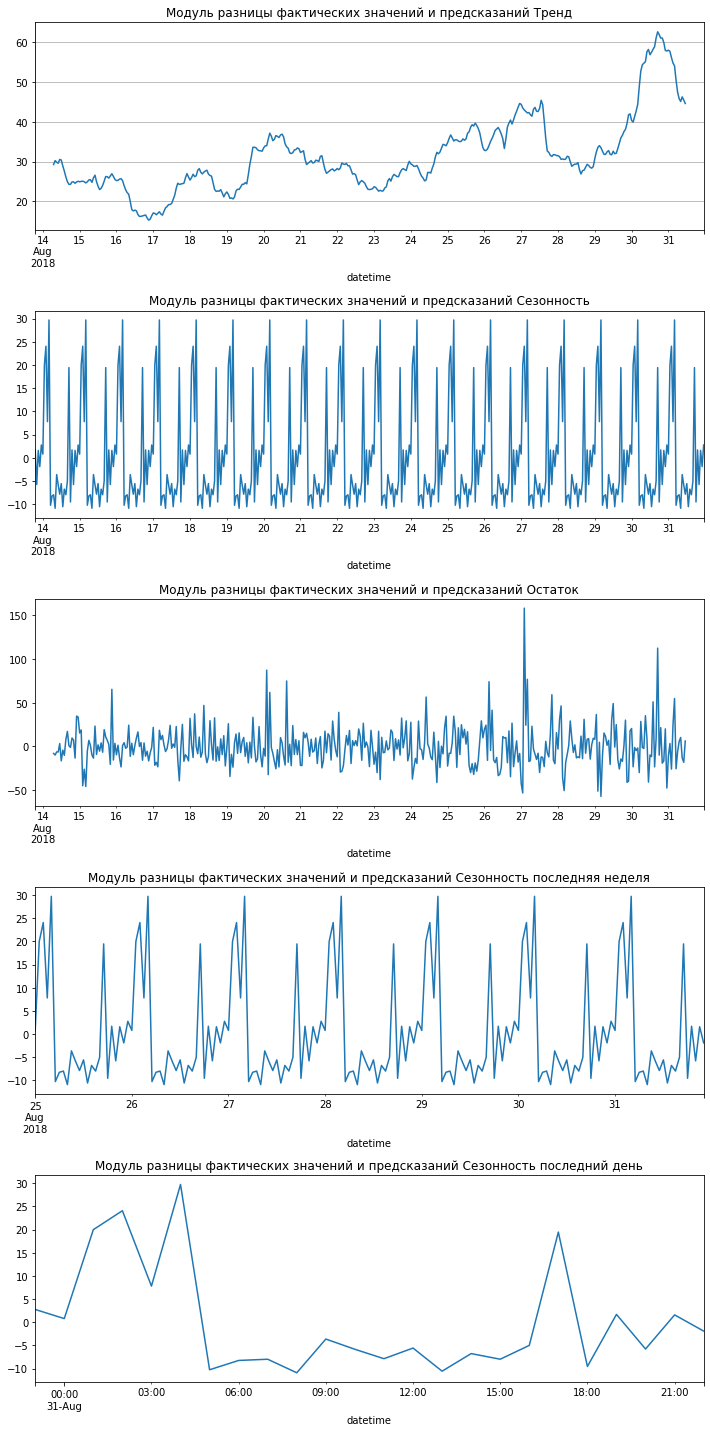

In [25]:
y_pred_test = run_catboost(X_train, X_test, y_train, y_test, 2)
visualization_pred(y_test, y_pred_test)

RMSE 42 - задание выполнено. У нашей модели есть тренд на увелечение ошибки. Так же видим сезонные ошибки, например наша модель регулярно ошибается в 4 утра на 30 заказов

### Вывод

Используя библиотеку CatBoost мы создали модель дающую RMSE 42 (на обычной линейной регрессии мы получили 43.6). Результаты лучше константных способов предсказаний. Важным фактором оказалось создание большого количества признаков из отстающих значений и скользящего среднего.  
При этом мы видим, что ошибка нашей модели имеет сезонность - думаю это признак того, что модель точно есть куда улучшать.